In [1]:
from manim import *

config.media_width = "100%"
_RV = "-v WARNING -qm --progress_bar None --disable_caching Example"
_RI = "-v WARNING -s --progress_bar None --disable_caching Example"

Manim Community v0.17.2

In [2]:
from scipy import integrate
import numdifftools as nd

import matplotlib.pyplot as plt

## Clase `CargaPuntual2D`

También sirve para el campo eléctrico de una esfera cargada en la parte de afuera de dicha esfera.

(falta validar que le campo dentro de la esfera sea nulo, pues no se consideran dipolos dentro de la esfera)

In [3]:
class CargaPuntual2D(VMobject):

    def __init__(self, pos=np.array([0, 0, 0]), q=1.6e-19, q_draw=1):
        
        super().__init__()
        
        self.pos = pos
        self.q = q
        self.q_draw = q_draw
        self.k = 8.99e9
        
        self.create()
        
        
    def create(self):
        
        #carga = Dot(color=RED if self.q_draw > 0 else BLUE).scale(2).move_to(self.pos)
        carga = Circle(radius=0.15, color=RED_B if self.q_draw > 0 else BLUE_B)\
                .set_fill(RED_E if self.q_draw > 0 else BLUE_E, 1).move_to(self.pos)
        
        self.add(carga)
        
        
    def campo(self, r, q, k):
        
        # TODO: validar en donde esta la carga y su interior, porque ahi el campo lo haré cero
        #       porque no podrá pasar nunca a la parte de adentro un dipolo (o un virus)
        
        x, y, z = r
        
        denominador = (((x - self.pos[0])**2 + (y - self.pos[1])**2 + (z - self.pos[2])**2)**(3/2))
        
        return np.array([
            k * (x - self.pos[0]) * q / denominador if denominador != 0 else 0, # x coord
            k * (y - self.pos[1]) * q / denominador if denominador != 0 else 0, # y coord
            k * (z - self.pos[2]) * q / denominador if denominador != 0 else 0  # z coord
        ])
    
    
    def campo_draw(self, r):
        return self.campo(r, self.q_draw, 1)
    
    
    def campo_real(self, r):
        return self.campo(r, self.q, self.k)


## Clase `DipoloElectrico2D` v1


Esta versión calcula el ángulo y la traslación por separado

In [128]:
class DipoloElectrico2D(VMobject):
    

    def __init__(self, angle, pos=np.array([6e-3, 6e-3, 0]), 
                 t_start=0, t_end=30, ele=140e-9, q=1.6e-19, m=1e-16, fields=[], 
                 pos_draw=np.array([0, 0, 0]),
                 longitud_escala=[40e-9, 140e-9], fps=30):
        
        super().__init__()
        
        self.angle = angle  # con respecto al campo total
        self.pos = pos
        self.t_start = t_start
        self.t_end = t_end
        self.ele = ele
        self.q1 = q
        self.q2 = -q
        self.m = m                # masa del proton mas electron = 1.67271e-27
        self.fields = fields
        self.pos_draw = pos_draw
        self.longitud_escala = longitud_escala
        self.fps = int(fps)
        
        self.dE = nd.Jacobian(self.campo_en_punto) # gradiente o jacobiano, es lo mismo ya que es una función vectorial
        
        self.create()
        self.calculate_dynamics()
        
    def create(self):
        
        longiud2 = self.escalar([self.ele], self.longitud_escala, [0.15, 0.8])[0]
        stroke_w = self.escalar([self.ele], self.longitud_escala, [4, 9])[0]
        scaledot = self.escalar([self.ele], self.longitud_escala, [1, 3])[0]
        
        linea = Line(LEFT * longiud2, RIGHT * longiud2, stroke_width=stroke_w) # 0.15 - 0.8, 4 - 9
        
        polo_positivo = Dot(color=RED).scale(scaledot).move_to(linea.get_end())    # 1 - 3
        polo_negativo = Dot(color=BLUE).scale(scaledot).move_to(linea.get_start()) # 1 - 3
        
        linea.add(polo_positivo, polo_negativo)
        
        self.add(linea)
        
        self.move_to(self.pos_draw)
        

    def calculate_dynamics(self):
        
        theta = self.angle  # angulo inicial
        omega = 0.0         # velocidad angular inicial
        
        # asumiendo que el centro de ele está en el origen
        r_pos = np.array([(self.ele/2)*np.cos(theta), (self.ele/2)*np.sin(theta), 0])    # carga positva
        r_neg = np.array([-(self.ele/2)*np.cos(theta), -(self.ele/2)*np.sin(theta), 0])  # carga negativa
        
        #l = r_neg - r_pos
        l = r_pos - r_neg
        p = l * self.q1
        
        #I = self.momento_inercia_dos_masas(self.m, l)
        I = self.momento_inercia_esfera_solida(self.m, l)
        
        E = self.campo_en_punto(self.pos)

        # calculos para ver como son los numeros y sus ordenes de magnitud (la menos al inicio del desma)

        tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
        dE_r = self.dE(self.pos)
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        
        print("r_pos =", r_pos)
        print("r_neg =", r_neg)
        print("l =", l)
        print("p =", p)
        print("I =", I)
        print("E =", E)
        print('tau =', tau)
        print("dE_r =", dE_r)
        print("alpha =", tau / I)
        print("a_x =", ax)
        print("------------")
        print("iterations =", self.t_end * self.fps + 2)
        print("[theta, omega] = ", [theta, omega])

        
        
        self.count_steps = 0
        self.solution_A = integrate.solve_ivp(self.angulo_dipolo, 
                                            [self.t_start, self.t_end], 
                                            [theta, omega],
                                            method='Radau',#'RK45'
                                            t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2),
                                            args=(I, p),
                                            vectorized=True
                                           )
        
        print("self.count_steps =", self.count_steps)
        print("------------")
        # sumar el angulo del campo E (en la posicion del dipolo, sin traslacion, ésta no cambia)
        E_angle = np.arctan2(E[1], E[0])
        print("E_angle =", E_angle)
        self.solution_and_E_angle = self.solution_A.y[0] + E_angle
        
        self.solution_F = integrate.solve_ivp(self.traslacion_dipolo, 
                                              [self.t_start, self.t_end], 
                                              [self.pos[0], self.pos[1], self.pos[2], 0, 0, 0],
                                              method='RK45',#'Radau',#'RK45'
                                              t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2),
                                              args=(p,)
                                             )
        
    def angulo_dipolo(self, t, theta, I, p):
    
        #print("self.count_steps =", self.count_steps)
        self.count_steps = self.count_steps + 1
    
        # componentes
        x, v = theta    # x: theta, v: omega
        
        E = self.campo_en_punto(self.pos)  # debe cambiar cuando haya traslacion
        
        tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(x)
        
        a = -tau / I if I != 0 else 0  # tau es negativa por la regla de la mano derecha, va hacia adentro de la página
        
        #print("a en angulo_dipolo:", a)

        return [v, a]  # velocidad (omega, primera derivada) y aceleración (alpha, segunda derivada)
    
    
    def traslacion_dipolo(self, t, r, p):
        
        # componentes
        x, y, z, vx, vy, vz = r
        
        dE_r = self.dE([x, y, z])
        
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        ay = ( 1/self.m ) * (p[0] * dE_r[1][0] + p[1] * dE_r[1][1] + p[2] * dE_r[1][2])
        az = ( 1/self.m ) * (p[0] * dE_r[2][0] + p[1] * dE_r[2][1] + p[2] * dE_r[2][2])
        
        return [vx, vy, vz, ax, ay, az]


    def momento_inercia_barra(self, m, l):

        #return np.array([m * l[0]**2, m * l[1]**2, m * l[2]**2]) / 12
        return m * np.linalg.norm(l)**2 / 12
    
        
    def momento_inercia_dos_masas(self, m, l): 
        # m es la masa total, entonces m1 = m2 = m/2
        # usa la masa reducida = m1m2/(m1+m2) = (m^2/4) / (m) = m/4
        
        return m * np.linalg.norm(l)**2 / 4
    
    
    def momento_inercia_esfera_solida(self, m, l):
        # aqui se considera el radio (no el diametro)
        
        return 2 * m * (np.linalg.norm(l)/2)**2 / 5
    
    
    def campo_en_punto(self, r):
        
        total_field = np.array([0., 0., 0.])
        for field in self.fields:
            total_field += field.campo_real(r)
        
        return total_field
    
    
    def escalar(self, values, actual_bounds, desired_bounds):
        return [
            desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0])
            / (actual_bounds[1] - actual_bounds[0]) 
            for x in values
        ]

### Validar el funcionamiento

Justo como en el notebook anterior (_03_), que si realice los cálculos, que haya movimiento angular y desplazamiento.

Test de v1:

In [129]:
fields = [
    CargaPuntual2D()
]


dipolo = DipoloElectrico2D(PI/3, pos_draw=np.array([1, 1, 0]), t_end=30,
                           fps=30, 
                           fields=fields)

r_pos = [3.50000000e-08 6.06217783e-08 0.00000000e+00]
r_neg = [-3.50000000e-08 -6.06217783e-08  0.00000000e+00]
l = [7.00000000e-08 1.21243557e-07 0.00000000e+00]
p = [1.1200000e-26 1.9398969e-26 0.0000000e+00]
I = 1.9600000000000001e-31
E = [1.41264221e-05 1.41264221e-05 0.00000000e+00]
tau = 3.8754829269443356e-31
dE_r = [[-0.0011772  -0.00353161  0.        ]
 [-0.00353161 -0.0011772   0.        ]
 [ 0.          0.          0.0023544 ]]
alpha = 1.9772872076246608
a_x = -8.169416711861027e-13
------------
iterations = 902
[theta, omega] =  [1.0471975511965976, 0.0]
self.count_steps = 636
------------
E_angle = 0.7853981633974483


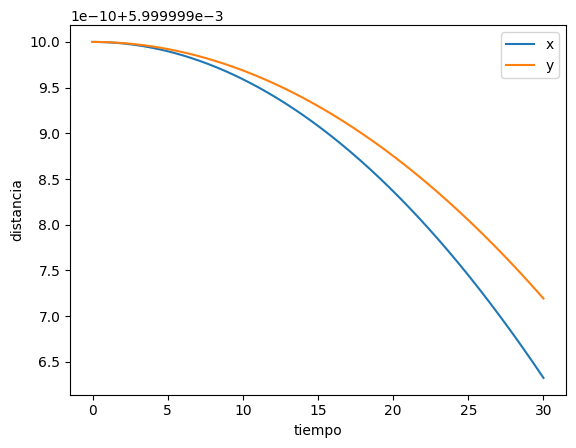

In [130]:
plt.plot(dipolo.solution_F.t, dipolo.solution_F.y[0], label="x")
plt.plot(dipolo.solution_F.t, dipolo.solution_F.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

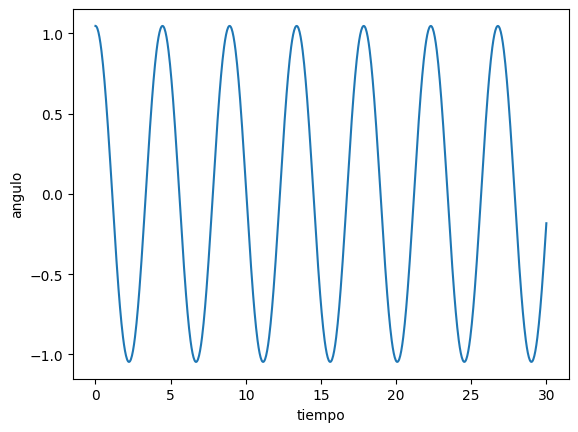

In [131]:
plt.plot(dipolo.solution_A.t, dipolo.solution_A.y[0])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

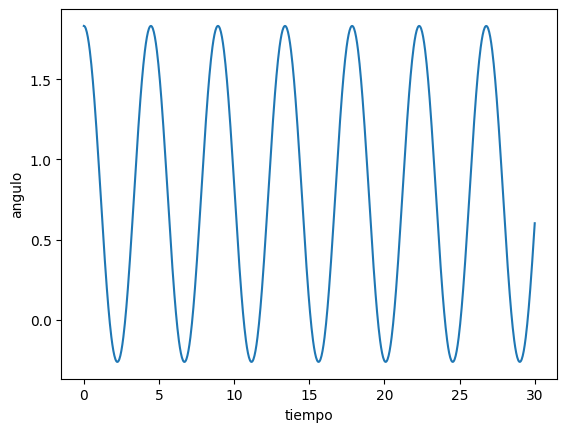

In [133]:
plt.plot(dipolo.solution_A.t, dipolo.solution_and_E_angle)
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

## Clase `DipoloElectrico2D` v2


Esta versión calcula el ángulo y la traslación con el momento dipolar ($p$) actualizado en cada paso

In [134]:
class DipoloElectrico2D(VMobject):
    

    def __init__(self, angle, pos=np.array([6e-3, 6e-3, 0]), 
                 t_start=0, t_end=30, ele=140e-9, q=1.6e-19, m=1e-16, fields=[], 
                 pos_draw=np.array([0, 0, 0]),
                 longitud_escala=[40e-9, 140e-9], fps=30):
        
        super().__init__()
        
        self.angle = angle  # con respecto al eje horizontal del sistema coordenado de referencia
        self.pos = pos
        self.t_start = t_start
        self.t_end = t_end
        self.ele = ele
        self.q1 = q
        self.q2 = -q
        self.m = m
        self.fields = fields
        self.pos_draw = pos_draw
        self.longitud_escala = longitud_escala
        self.fps = int(fps)
        
        self.dE = nd.Jacobian(self.campo_en_punto) # gradiente o jacobiano, es lo mismo ya que es una función vectorial
        
        self.create()
        self.calculate_dynamics()
        
    def create(self):
        
        longiud2 = self.escalar([self.ele], self.longitud_escala, [0.15, 0.8])[0]
        stroke_w = self.escalar([self.ele], self.longitud_escala, [4, 9])[0]
        scaledot = self.escalar([self.ele], self.longitud_escala, [1, 3])[0]
        
        linea = Line(LEFT * longiud2, RIGHT * longiud2, stroke_width=stroke_w) # 0.15 - 0.8, 4 - 9
        
        polo_positivo = Dot(color=RED).scale(scaledot).move_to(linea.get_end())    # 1 - 3
        polo_negativo = Dot(color=BLUE).scale(scaledot).move_to(linea.get_start()) # 1 - 3
        
        linea.add(polo_positivo, polo_negativo)
        
        self.add(linea)
        
        self.move_to(self.pos_draw)
        

    def calculate_dynamics(self):
        
        theta = self.angle  # angulo inicial
        omega = 0.0         # velocidad angular inicial
        
        # asumiendo que el centro de ele está en el origen
        #r_pos = np.array([(self.ele/2)*np.cos(theta), (self.ele/2)*np.sin(theta), 0])    # carga positva
        #r_neg = np.array([-(self.ele/2)*np.cos(theta), -(self.ele/2)*np.sin(theta), 0])  # carga negativa
        
        #l = r_neg - r_pos
        #l = r_pos - r_neg
        #p = l * self.q1
        p, l = self.momento_dipolar(theta, self.pos)
        
        #I = self.momento_inercia_dos_masas(self.m, l)
        self.I = self.momento_inercia_esfera_solida(self.m, l)
        
        E = self.campo_en_punto(self.pos)

        # calculos para ver como son los números y sus ordenes de magnitud (la menos al inicio del desma)

        #tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
        tau = np.cross(p, E)[2] # el valor de tau queda en la coordenada z y con el signo correcto
        dE_r = self.dE(self.pos)
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        
        print("theta =", theta)
        print("self.pos[0] =", self.pos[0])
        print("l =", l)
        print("p =", p)
        print("I =", self.I)
        print("E =", E)
        print('tau =', tau)
        print("dE_r =", dE_r)
        print("alpha =", tau / self.I)
        print("a_x =", ax)
        print("------------")
        print("iterations =", self.t_end * self.fps + 2)
        print("[theta, omega] = ", [theta, omega])

        
        
        self.count_steps = 0
        self.solution_A = integrate.solve_ivp(self.angulo_dipolo, 
                                            [self.t_start, self.t_end], 
                                            [theta, omega],
                                            method='Radau',#'RK45'
                                            t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2),
                                            #args=(I,), #args(I, p)
                                            #vectorized=True
                                           )
        
        print("self.count_steps =", self.count_steps)
        print("------------")
        # sumar el angulo del campo E (en la posicion del dipolo, sin traslacion, ésta no cambia)
        #E_angle = np.arctan2(E[1], E[0])
        #print("E_angle =", E_angle)
        #self.solution_and_E_angle = self.solution_A.y[0] + E_angle
        
        self.solution_F = integrate.solve_ivp(self.traslacion_dipolo, 
                                              [self.t_start, self.t_end], 
                                              [self.pos[0], self.pos[1], self.pos[2], 0, 0, 0],
                                              method='RK45',#'Radau',#'RK45'
                                              t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2),
                                              #args=(p,)
                                             )
        
    def angulo_dipolo(self, t, theta):
    
        #print("theta en angulo_dipolo:", theta)
    
        #print("self.count_steps =", self.count_steps)
        self.count_steps = self.count_steps + 1
    
        # componentes
        x, v = theta    # x: theta, v: omega
        
        p, _ = self.momento_dipolar(x, self.pos) # debe cambiar cuando haya traslacion
        
        E = self.campo_en_punto(self.pos)    # debe cambiar cuando haya traslacion
        
        #tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
        tau = np.cross(p, E)[2] # el valor de tau queda en la coordenada z y con el signo correcto
        
        #a = -tau / I if I != 0 else 0  # tau es negativa por la regla de la mano derecha, va hacia adentro de la página
        a = tau / self.I if self.I != 0 else 0  # el signo ya lo trae tau
        
        #print("a en angulo_dipolo:", a)
        
        #print("return en angulo_dipolo:", [v, a])

        return [v, a]  # velocidad (omega, primera derivada) y aceleración (alpha, segunda derivada)
    
    
    def traslacion_dipolo(self, t, r):
        
        #print("r en traslacion_dipolo:", r)
        
        # componentes
        x, y, z, vx, vy, vz = r
        
        dE_r = self.dE([x, y, z])
        
        p, _ = self.momento_dipolar(self.angle, np.array([x, y, z])) # e angulo debe ser el actual
        
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        ay = ( 1/self.m ) * (p[0] * dE_r[1][0] + p[1] * dE_r[1][1] + p[2] * dE_r[1][2])
        az = ( 1/self.m ) * (p[0] * dE_r[2][0] + p[1] * dE_r[2][1] + p[2] * dE_r[2][2])
        
        #print("return en traslacion_dipolo:", [vx, vy, vz, ax, ay, az])
        
        return [vx, vy, vz, ax, ay, az]

    
    def momento_dipolar(self, angle, center_pos):
        
        # asumiendo que el centro de ele está en center_pos
        r_pos = np.array([(self.ele/2)*np.cos(angle), (self.ele/2)*np.sin(angle), 0]) + center_pos   # carga positva
        r_neg = np.array([-(self.ele/2)*np.cos(angle), -(self.ele/2)*np.sin(angle), 0]) + center_pos # carga negativa
        
        l = r_pos - r_neg
        p = l * self.q1
        
        #print("r_pos =", r_pos)
        #print("r_neg =", r_neg)
        
        return p, l
    

    def momento_inercia_barra(self, m, l):

        #return np.array([m * l[0]**2, m * l[1]**2, m * l[2]**2]) / 12
        return m * np.linalg.norm(l)**2 / 12
    
        
    def momento_inercia_dos_masas(self, m, l): 
        # m es la masa total, entonces m1 = m2 = m/2
        # usa la masa reducida = m1m2/(m1+m2) = (m^2/4) / (m) = m/4
        
        return m * np.linalg.norm(l)**2 / 4
    
    
    def momento_inercia_esfera_solida(self, m, l):
        # aqui se considera el radio (no el diametro)
        
        return 2 * m * (np.linalg.norm(l)/2)**2 / 5
    
    
    def campo_en_punto(self, r):
        
        total_field = np.array([0., 0., 0.])
        for field in self.fields:
            total_field += field.campo_real(r)
        
        return total_field
    
    
    def escalar(self, values, actual_bounds, desired_bounds):
        return [
            desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0])
            / (actual_bounds[1] - actual_bounds[0]) 
            for x in values
        ]

Ángulo de un vector: $\tan^{-1}\left(\frac{y}{x}\right)$

Esto se calcula correctamente con la función `np.arctan2`:

In [11]:
np.arctan2(1, 1)

0.7853981633974483

In [12]:
np.arctan2(0, 1)

0.0

In [17]:
np.arctan2(0, -1)

3.141592653589793

In [15]:
np.arctan2(1, 0)

1.5707963267948966

In [16]:
np.arctan2(-1, 0)

-1.5707963267948966

In [43]:
np.arctan2(5/100, -1) * 180/PI

177.13759477388828

In [44]:
np.arctan2(-5/100, -1) * 180/PI

-177.13759477388828

In [47]:
p_angle = np.arctan2(5/100, -1)
E_angle = np.arctan2(-5/100, -1)

angle_between_vectors = p_angle - E_angle

print("angle_between_vectors =", angle_between_vectors * 180/PI)

angle_between_vectors = 354.27518954777656


In [48]:
p_angle = np.arctan2(5/100, -1)
E_angle = np.arctan2(1, 1)

angle_between_vectors = p_angle - E_angle

print("angle_between_vectors =", angle_between_vectors * 180/PI)

angle_between_vectors = 132.13759477388828


In [49]:
p_angle = np.arctan2(5/100, 1)
E_angle = np.arctan2(1, 1)

angle_between_vectors = p_angle - E_angle

print("angle_between_vectors =", angle_between_vectors * 180/PI)

angle_between_vectors = -42.13759477388826


Para calcular $\tau$ puedo usar la versión de calcular su magnitud:

$$|\vec{\tau}|=|\vec{p}||\vec{E}| \, \cos\theta$$

donde $\theta$ es el ángulo entre los dos vectores

Considerando la figura 3.2 de mi documento, la dirección de $\vec{\tau}$ es hacia adentro de la pnatalla, es decir negativa, por lo que al calcular tau se deb agregar un signo negativo.

La otra es usar el proucto punto, tal cual es la deficio´n de $\vec{\tau}$:

$$\vec{\tau}=\vec{p}\times\vec{E}$$

lo que se calcula con `np.cross`:

In [50]:
p = np.array([2, 3, 0])
E = np.array([3, 1, 0])

tau = np.cross(p, E)

print("tau =", tau)

tau = [ 0  0 -7]


In [51]:
p = np.array([3, -1, 0])
E = np.array([3,  3, 0])

tau = np.cross(p, E)

print("tau =", tau)

tau = [ 0  0 12]


In [135]:
p = np.array([3, -1, 1])
E = np.array([3,  3, -1])

tau = np.cross(p, E)

print("tau =", tau)

tau = [-2  6 12]


Corroborando resultados en la v1 de los cálculos:

    r_pos = [3.50000000e-08 6.06217783e-08 0.00000000e+00]
    r_neg = [-3.50000000e-08 -6.06217783e-08  0.00000000e+00]
    l = [7.00000000e-08 1.21243557e-07 0.00000000e+00]
    p = [1.1200000e-26 1.9398969e-26 0.0000000e+00]
    I = 1.9600000000000001e-31
    E = [1.41264221e-05 1.41264221e-05 0.00000000e+00]
    tau = 3.8754829269443356e-31
    dE_r = [[-0.0011772  -0.00353161  0.        ]
     [-0.00353161 -0.0011772   0.        ]
     [ 0.          0.          0.0023544 ]]
    alpha = 1.9772872076246608
    a_x = -8.169416711861027e-13
    ------------
    iterations = 902
    [theta, omega] =  [1.0471975511965976, 0.0]
    self.count_steps = 636
    ------------
    E_angle = 0.7853981633974483

In [136]:
E = np.array([1.41264221e-05, 1.41264221e-05, 0.00000000e+00])
p = np.array([1.1200000e-26, 1.9398969e-26, 0.0000000e+00])

tau = np.cross(p, E)
print("tau con producto cruz =", tau[2]) # el valor buscado ensta en el eje z con el signo correcto


p_angle = np.arctan2(p[1], p[0])
E_angle = np.arctan2(E[1], E[0])

angle_between_vectors = p_angle - E_angle

tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(angle_between_vectors)
print("tau con formula alternativa =", tau) # aqui se debe poner a mano el signo negativo


tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(E_angle)
print("tau con formula alternativa y angulo de E solamente =", tau) # este es un calculo erroneao de tau porque el angulo
                                                                    # es de E con el eje x y no con p
# ya no estoy segura que resulte en lo mismo al final restar el angulo de E a los angulos obtenidos en los calculos
# que consideran el angulo de E con el eje, en lugar de el angulo de E con p

tau con producto cruz = -1.1582209687881492e-31
tau con formula alternativa = 1.1582209687881498e-31
tau con formula alternativa y angulo de E solamente = 3.164318544922736e-31


Test de v2:

(si se ve igual que el test de arriba de v1)

In [143]:
fields = [
    CargaPuntual2D()
]


dipolo = DipoloElectrico2D(7*PI/12, pos_draw=np.array([1, 1, 0]), t_end=30,  # angle = PI/3 + PI/4
                           fps=30, 
                           fields=fields)

theta = 1.832595714594046
self.pos[0] = 0.006
l = [-3.62346663e-08  1.35229616e-07  0.00000000e+00]
p = [-5.79754661e-27  2.16367385e-26  0.00000000e+00]
I = 1.9600000000058271e-31
E = [1.41264221e-05 1.41264221e-05 0.00000000e+00]
tau = -3.8754829269481897e-31
dE_r = [[-0.0011772  -0.00353161  0.        ]
 [-0.00353161 -0.0011772   0.        ]
 [ 0.          0.          0.0023544 ]]
alpha = -1.9772872076207488
a_x = -6.958754291404718e-13
------------
iterations = 902
[theta, omega] =  [1.832595714594046, 0.0]
self.count_steps = 741
------------


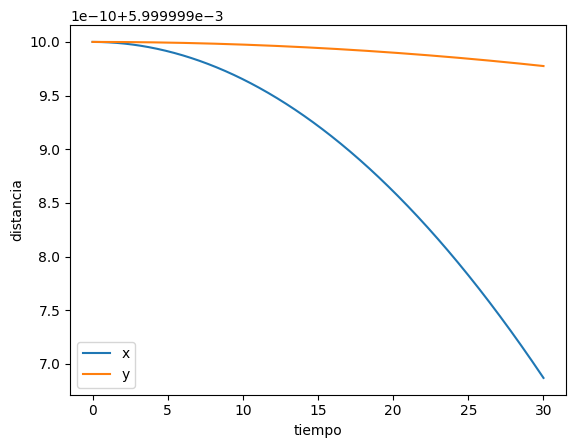

In [144]:
plt.plot(dipolo.solution_F.t, dipolo.solution_F.y[0], label="x")
plt.plot(dipolo.solution_F.t, dipolo.solution_F.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

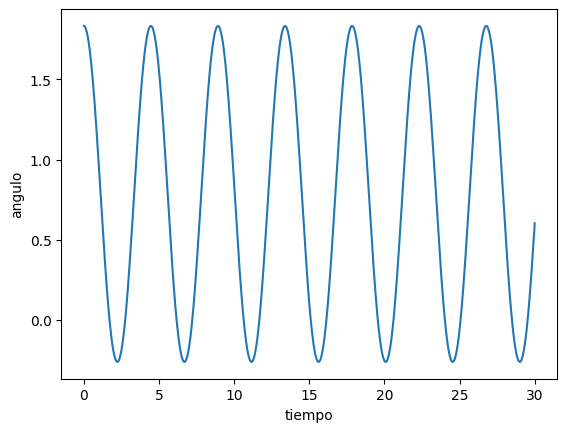

In [145]:
plt.plot(dipolo.solution_A.t, dipolo.solution_A.y[0])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

Con el dipolo alineado al campo:

In [146]:
fields = [
    CargaPuntual2D()
]


dipolo = DipoloElectrico2D(PI/4, pos_draw=np.array([1, 1, 0]), t_end=30,  # angle = PI/4, igual al del campo E
                           fps=30, 
                           fields=fields)

theta = 0.7853981633974483
self.pos[0] = 0.006
l = [9.89949494e-08 9.89949494e-08 0.00000000e+00]
p = [1.58391919e-26 1.58391919e-26 0.00000000e+00]
I = 1.960000000011614e-31
E = [1.41264221e-05 1.41264221e-05 0.00000000e+00]
tau = 0.0
dE_r = [[-0.0011772  -0.00353161  0.        ]
 [-0.00353161 -0.0011772   0.        ]
 [ 0.          0.          0.0023544 ]]
alpha = 0.0
a_x = -7.458370370791742e-13
------------
iterations = 902
[theta, omega] =  [0.7853981633974483, 0.0]
self.count_steps = 40
------------


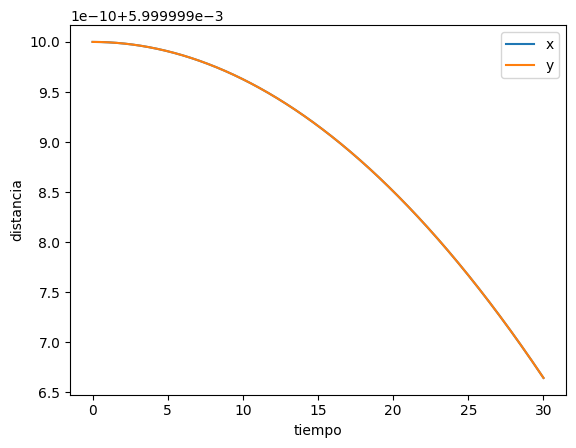

In [147]:
plt.plot(dipolo.solution_F.t, dipolo.solution_F.y[0], label="x")
plt.plot(dipolo.solution_F.t, dipolo.solution_F.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

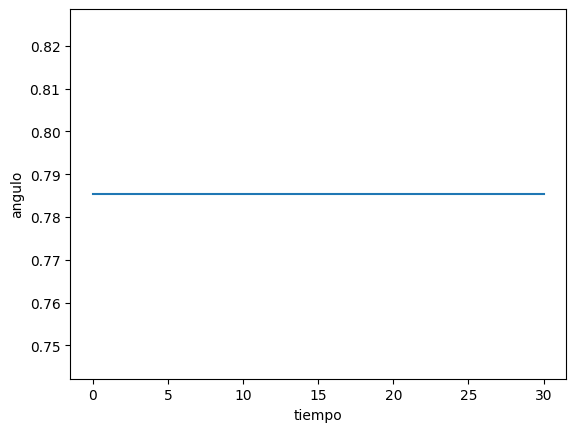

In [148]:
plt.plot(dipolo.solution_A.t, dipolo.solution_A.y[0])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

## Clase `DipoloElectrico2D` v3


Esta versión calcula el ángulo y la traslación con el momento dipolar ($p$) actualizado en cada paso y todo en el mismo método, ángulo y desplazamiento a la vez, para usar los valores actualizados en ambos casos.

In [197]:
class DipoloElectrico2D(VMobject):
    

    def __init__(self, angle, pos=np.array([6e-3, 6e-3, 0]), 
                 t_start=0, t_end=30, ele=140e-9, q=1.6e-19, m=1e-16, fields=[], 
                 pos_draw=np.array([0, 0, 0]),
                 longitud_escala=[40e-9, 140e-9], fps=30,
                 set_time_interval=True):
        
        super().__init__()
        
        self.angle = angle  # con respecto al eje horizontal del sistema coordenado de referencia
        self.pos = pos
        self.t_start = t_start
        self.t_end = t_end
        self.ele = ele
        self.q1 = q
        self.q2 = -q
        self.m = m
        self.fields = fields
        self.pos_draw = pos_draw
        self.longitud_escala = longitud_escala
        self.fps = int(fps)
        self.set_time_interval = set_time_interval
        
        self.dE = nd.Jacobian(self.campo_en_punto) # gradiente o jacobiano, es lo mismo ya que es una función vectorial
        
        self.create()
        self.calculate_dynamics()
        
    def create(self):
        
        longiud2 = self.escalar([self.ele], self.longitud_escala, [0.15, 0.8])[0]
        stroke_w = self.escalar([self.ele], self.longitud_escala, [4, 9])[0]
        scaledot = self.escalar([self.ele], self.longitud_escala, [1, 3])[0]
        
        linea = Line(LEFT * longiud2, RIGHT * longiud2, stroke_width=stroke_w) # 0.15 - 0.8, 4 - 9
        
        polo_positivo = Dot(color=RED).scale(scaledot).move_to(linea.get_end())    # 1 - 3
        polo_negativo = Dot(color=BLUE).scale(scaledot).move_to(linea.get_start()) # 1 - 3
        
        linea.add(polo_positivo, polo_negativo)
        
        self.add(linea)
        
        self.move_to(self.pos_draw)
        

    def calculate_dynamics(self):
        
        theta = self.angle  # angulo inicial
        omega = 0.0         # velocidad angular inicial
        
        # asumiendo que el centro de ele está en el origen
        #r_pos = np.array([(self.ele/2)*np.cos(theta), (self.ele/2)*np.sin(theta), 0])    # carga positva
        #r_neg = np.array([-(self.ele/2)*np.cos(theta), -(self.ele/2)*np.sin(theta), 0])  # carga negativa
        
        #l = r_neg - r_pos
        #l = r_pos - r_neg
        #p = l * self.q1
        p, l = self.momento_dipolar(theta, self.pos)
        
        #I = self.momento_inercia_dos_masas(self.m, l)
        self.I = self.momento_inercia_esfera_solida(self.m, l)
        
        E = self.campo_en_punto(self.pos)

        # calculos para ver como son los números y sus ordenes de magnitud (la menos al inicio del desma)

        #tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
        tau = np.cross(p, E)[2] # el valor de tau queda en la coordenada z y con el signo correcto
        dE_r = self.dE(self.pos)
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        
        print("theta =", theta)
        print("self.pos[0] =", self.pos[0])
        print("l =", l)
        print("p =", p)
        print("I =", self.I)
        print("E =", E)
        print('tau =', tau)
        print("dE_r =", dE_r)
        print("alpha =", tau / self.I)
        print("a_x =", ax)
        print("------------")
        print("iterations =", self.t_end * self.fps + 2)
        print("[theta, omega] = ", [theta, omega])

        
        
        self.count_steps = 0
#         self.solution_A = integrate.solve_ivp(self.angulo_dipolo, 
#                                             [self.t_start, self.t_end], 
#                                             [theta, omega],
#                                             method='Radau',#'RK45'
#                                             t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2),
#                                             #args=(I,), #args(I, p)
#                                             #vectorized=True
#                                            )
        
#         print("self.count_steps =", self.count_steps)
#         print("------------")
#         # sumar el angulo del campo E (en la posicion del dipolo, sin traslacion, ésta no cambia)
#         #E_angle = np.arctan2(E[1], E[0])
#         #print("E_angle =", E_angle)
#         #self.solution_and_E_angle = self.solution_A.y[0] + E_angle
        
#         self.solution_F = integrate.solve_ivp(self.traslacion_dipolo, 
#                                               [self.t_start, self.t_end], 
#                                               [self.pos[0], self.pos[1], self.pos[2], 0, 0, 0],
#                                               method='RK45',#'Radau',#'RK45'
#                                               t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2),
#                                               #args=(p,)
#                                              )

        self.solution = integrate.solve_ivp(self.movimiento_dipolo, 
                                            [self.t_start, self.t_end], 
                                            [self.pos[0], self.pos[1], self.pos[2], 0, 0, 0, theta, omega],
                                            method='Radau',#'RK45'
                                            t_eval=np.linspace(self.t_start, self.t_end, self.t_end * self.fps + 2)
                                                   if self.set_time_interval else None
                                           )
                                              
    
    def movimiento_dipolo(self, t, y):
        
        r = y[0:6]          # componentes de la traslacion
        theta = y[6:8]      # componentes de la rotación
        
        pos = r[0:3]        # posicion actual
        angle = theta[0]    # angulo actual
        
        p, l = self.momento_dipolar(angle, pos)  # en posicion actual
        
        y_traslacion = self.traslacion_dipolo(t, r, p)
        
        y_angulo = self.angulo_dipolo(t, theta, pos, p, l)
        
        return np.concatenate((y_traslacion, y_angulo))
        
        
        
    def angulo_dipolo(self, t, theta, pos, p, l):
    
        #print("theta en angulo_dipolo:", theta)
    
        #print("self.count_steps =", self.count_steps)
        self.count_steps = self.count_steps + 1
    
        # componentes
        x, v = theta    # x: theta, v: omega
        
        #p, _ = self.momento_dipolar(x, pos)  # en posicion actual
        
        I = self.momento_inercia_esfera_solida(self.m, l) # en posicion actual
        
        E = self.campo_en_punto(pos)         # en posicion actual
        
        #tau = np.linalg.norm(p) * np.linalg.norm(E) * np.sin(theta)
        tau = np.cross(p, E)[2] # el valor de tau queda en la coordenada z y con el signo correcto
        
        #a = -tau / I if I != 0 else 0  # tau es negativa por la regla de la mano derecha, va hacia adentro de la página
        a = tau / I if I != 0 else 0  # el signo ya lo trae tau
        
        #print("a en angulo_dipolo:", a)
        
        #print("return en angulo_dipolo:", [v, a])

        return [v, a]  # velocidad (omega, primera derivada) y aceleración (alpha, segunda derivada)
    
    
    def traslacion_dipolo(self, t, r, p):
        
        #print("r en traslacion_dipolo:", r)
        
        # componentes
        x, y, z, vx, vy, vz = r
        
        dE_r = self.dE([x, y, z])
        
        #p, _ = self.momento_dipolar(self.angle, np.array([x, y, z])) # e angulo debe ser el actual
        
        ax = ( 1/self.m ) * (p[0] * dE_r[0][0] + p[1] * dE_r[0][1] + p[2] * dE_r[0][2])
        ay = ( 1/self.m ) * (p[0] * dE_r[1][0] + p[1] * dE_r[1][1] + p[2] * dE_r[1][2])
        az = ( 1/self.m ) * (p[0] * dE_r[2][0] + p[1] * dE_r[2][1] + p[2] * dE_r[2][2])
        
        #print("return en traslacion_dipolo:", [vx, vy, vz, ax, ay, az])
        
        return [vx, vy, vz, ax, ay, az]

    
    def momento_dipolar(self, angle, center_pos):
        
        # asumiendo que el centro de ele está en center_pos
        r_pos = np.array([(self.ele/2)*np.cos(angle), (self.ele/2)*np.sin(angle), 0]) + center_pos   # carga positva
        r_neg = np.array([-(self.ele/2)*np.cos(angle), -(self.ele/2)*np.sin(angle), 0]) + center_pos # carga negativa
        
        l = r_pos - r_neg
        p = l * self.q1
        
        #print("r_pos =", r_pos)
        #print("r_neg =", r_neg)
        
        return p, l
    

    def momento_inercia_barra(self, m, l):

        #return np.array([m * l[0]**2, m * l[1]**2, m * l[2]**2]) / 12
        return m * np.linalg.norm(l)**2 / 12
    
        
    def momento_inercia_dos_masas(self, m, l): 
        # m es la masa total, entonces m1 = m2 = m/2
        # usa la masa reducida = m1m2/(m1+m2) = (m^2/4) / (m) = m/4
        
        return m * np.linalg.norm(l)**2 / 4
    
    
    def momento_inercia_esfera_solida(self, m, l):
        # aqui se considera el radio (no el diametro)
        
        return 2 * m * (np.linalg.norm(l)/2)**2 / 5
    
    
    def campo_en_punto(self, r):
        
        total_field = np.array([0., 0., 0.])
        for field in self.fields:
            total_field += field.campo_real(r)
        
        return total_field
    
    
    def escalar(self, values, actual_bounds, desired_bounds):
        return [
            desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0])
            / (actual_bounds[1] - actual_bounds[0]) 
            for x in values
        ]

Algunas pruebas:

In [151]:
y = [1,2,3,4,5,6,7,8]
y[0:6]

[1, 2, 3, 4, 5, 6]

In [153]:
y[6:8]

[7, 8]

In [154]:
y[0:1]

[1]

In [156]:
a = [1,2,3]
b = [5,6,7,8]

np.concatenate((a, b))

array([1, 2, 3, 5, 6, 7, 8])

Test v3:

In [188]:
fields = [
    CargaPuntual2D()
]


dipolo = DipoloElectrico2D(-7*PI/12, pos_draw=np.array([1, 1, 0]), t_end=300,  # angle = PI/3 + PI/4
                           fps=30, 
                           fields=fields)

theta = -1.832595714594046
self.pos[0] = 0.006
l = [-3.62346663e-08 -1.35229616e-07  0.00000000e+00]
p = [-5.79754661e-27 -2.16367385e-26  0.00000000e+00]
I = 1.9600000000058271e-31
E = [1.41264221e-05 1.41264221e-05 0.00000000e+00]
tau = 2.2375111111177405e-31
dE_r = [[-0.0011772  -0.00353161  0.        ]
 [-0.00353161 -0.0011772   0.        ]
 [ 0.          0.          0.0023544 ]]
alpha = 1.14158730158729
a_x = 8.323730804650475e-13
------------
iterations = 9002
[theta, omega] =  [-1.832595714594046, 0.0]


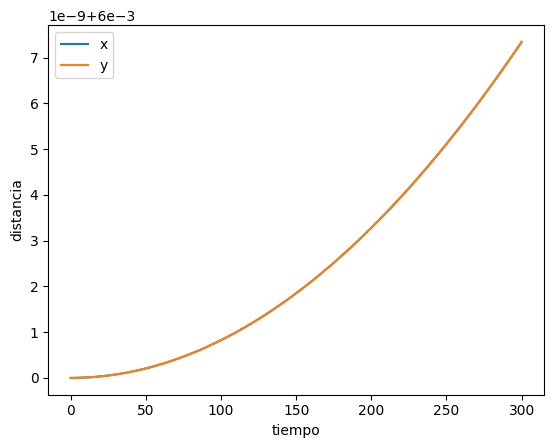

In [189]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

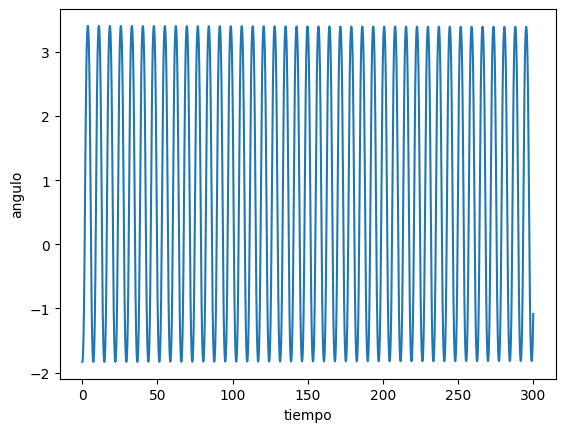

In [190]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

Veamos la animación:

In [191]:
TOTAL_TIME = 30


class Example(Scene):

    def construct(self):
        
        fields = [
            CargaPuntual2D()
        ]
        
        for field in fields:
            self.add(field)
            field.set_z_index(10)
        
        def func_e_field(p):
            total_field = np.array([0., 0., 0.])
            for field in fields:
                total_field += field.campo_draw(p)
            return total_field
        
        vector_field = ArrowVectorField(func_e_field)
        vector_field._alpha = 1
        
        def show_field(mob, dt):
            # valor de alpha que quiero quitar en 3 segundos, el dt se usa para que el calculo considere fps y TOTAL_TIME
            mob._alpha = mob._alpha - (0.65*dt/3) if mob._alpha > 0.35 else 0.35
            for subm in mob.submobjects:
                subm.set_opacity(mob._alpha)
            
        vector_field.add_updater(show_field)
        self.add(vector_field)
        
        
        initial_angle = -3*PI/4 # respecto al eje horizontal

        dipolo = DipoloElectrico2D(initial_angle, pos_draw=np.array([1, 1, 0]), t_end=TOTAL_TIME,
                                   fps=self.camera.frame_rate, 
                                   fields=fields,
                                   longitud_escala=[140e-9, 420e-9])
        dipolo.save_state()
        dipolo._counter = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            #mob.rotate(mob.solution.y[0][mob._counter])
            mob.rotate(mob.solution.y[6][mob._counter])
            mob.move_to([(mob.solution.y[0][mob._counter]-6e-3)/1e-11 + mob.pos_draw[0], 
                         (mob.solution.y[1][mob._counter]-6e-3)/1e-11 + mob.pos_draw[1], 
                         (mob.solution.y[2][mob._counter]-6e-3)/1e-11 + mob.pos_draw[2]])
            mob._counter += 1
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        
        
        self.wait(TOTAL_TIME)
        

%manim $_RV

theta = -2.356194490192345
self.pos[0] = 0.006
l = [-9.89949494e-08 -9.89949494e-08  0.00000000e+00]
p = [-1.58391919e-26 -1.58391919e-26  0.00000000e+00]
I = 1.960000000011614e-31
E = [1.41264221e-05 1.41264221e-05 0.00000000e+00]
tau = 0.0
dE_r = [[-0.0011772  -0.00353161  0.        ]
 [-0.00353161 -0.0011772   0.        ]
 [ 0.          0.          0.0023544 ]]
alpha = 0.0
a_x = 7.458370370791742e-13
------------
iterations = 902
[theta, omega] =  [-2.356194490192345, 0.0]


In [192]:
TOTAL_TIME = 30


class Example(Scene):

    def construct(self):
        
        fields = [
            CargaPuntual2D()
        ]
        
        for field in fields:
            self.add(field)
            field.set_z_index(10)
        
        def func_e_field(p):
            total_field = np.array([0., 0., 0.])
            for field in fields:
                total_field += field.campo_draw(p)
            return total_field
        
        vector_field = ArrowVectorField(func_e_field)
        vector_field._alpha = 1
        
        def show_field(mob, dt):
            # valor de alpha que quiero quitar en 3 segundos, el dt se usa para que el calculo considere fps y TOTAL_TIME
            mob._alpha = mob._alpha - (0.65*dt/3) if mob._alpha > 0.35 else 0.35
            for subm in mob.submobjects:
                subm.set_opacity(mob._alpha)
            
        vector_field.add_updater(show_field)
        self.add(vector_field)
        
        
        initial_angle = -PI/2 # respecto al eje horizontal

        dipolo = DipoloElectrico2D(initial_angle, pos_draw=np.array([1, 1, 0]), t_end=TOTAL_TIME,
                                   fps=self.camera.frame_rate, 
                                   fields=fields,
                                   longitud_escala=[140e-9, 420e-9])
        dipolo.save_state()
        dipolo._counter = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            #mob.rotate(mob.solution.y[0][mob._counter])
            mob.rotate(mob.solution.y[6][mob._counter])
            mob.move_to([(mob.solution.y[0][mob._counter]-6e-3)/1e-11 + mob.pos_draw[0], 
                         (mob.solution.y[1][mob._counter]-6e-3)/1e-11 + mob.pos_draw[1], 
                         (mob.solution.y[2][mob._counter]-6e-3)/1e-11 + mob.pos_draw[2]])
            mob._counter += 1
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        
        
        self.wait(TOTAL_TIME)
        

%manim $_RV

theta = -1.5707963267948966
self.pos[0] = 0.006
l = [ 0.0e+00 -1.4e-07  0.0e+00]
p = [ 0.00e+00 -2.24e-26  0.00e+00]
I = 1.9599999999767195e-31
E = [1.41264221e-05 1.41264221e-05 0.00000000e+00]
tau = 3.1643185592750344e-31
dE_r = [[-0.0011772  -0.00353161  0.        ]
 [-0.00353161 -0.0011772   0.        ]
 [ 0.          0.          0.0023544 ]]
alpha = 1.6144482445472548
a_x = 7.910796398648474e-13
------------
iterations = 902
[theta, omega] =  [-1.5707963267948966, 0.0]


In [204]:
fields = [
    CargaPuntual2D()
]


dipolo = DipoloElectrico2D(PI/3, pos_draw=np.array([1, 1, 0]), t_end=10,
                           fps=30, pos=np.array([1e-6, 1e-6, 0]),
                           fields=fields,
                           set_time_interval=False)

theta = 1.0471975511965976
self.pos[0] = 1e-06
l = [7.00000000e-08 1.21243557e-07 0.00000000e+00]
p = [1.1200000e-26 1.9398969e-26 0.0000000e+00]
I = 1.9600000000000039e-31
E = [508.55119703 508.55119703   0.        ]
tau = -4.1695955221252065e-24
dE_r = [[ 1.14304449e-18  7.14134823e-31  0.00000000e+00]
 [ 7.14134823e-31  1.14304449e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.28608899e-18]]
alpha = -21273446.541455094
a_x = 1.2802098316462741e-28
------------
iterations = 302
[theta, omega] =  [1.0471975511965976, 0.0]


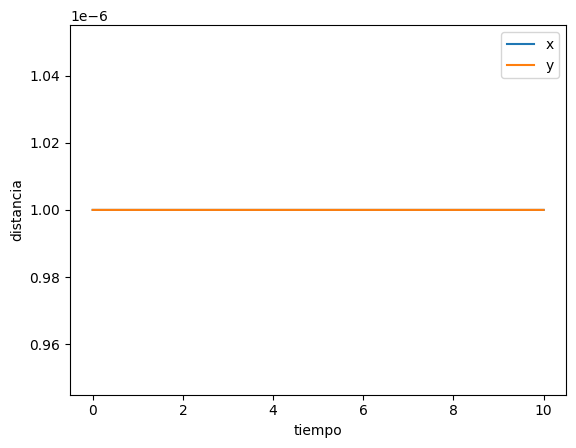

In [205]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

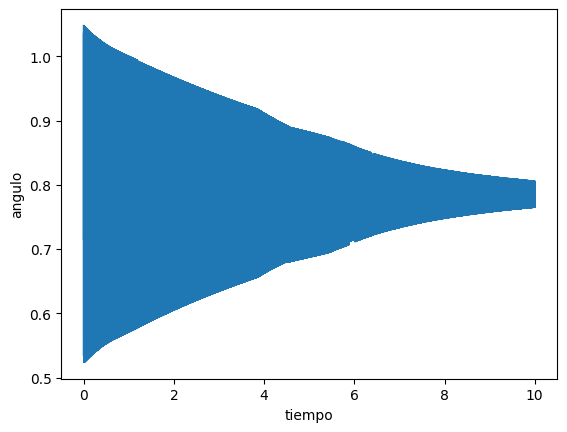

In [206]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [208]:
len(dipolo.solution.t)

137318

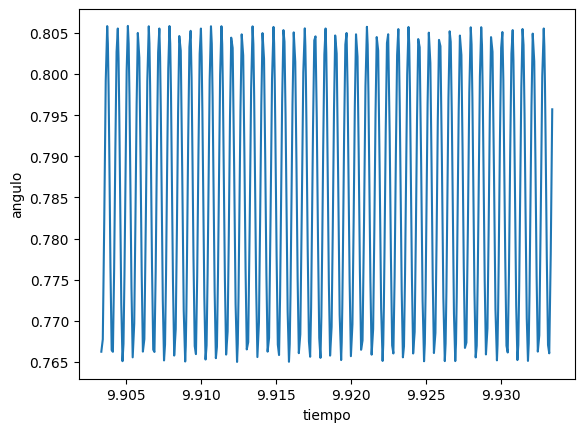

In [209]:
plt.plot(dipolo.solution.t[136018:136418], dipolo.solution.y[6][136018:136418])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [210]:
fields = [
    CargaPuntual2D()
]


dipolo = DipoloElectrico2D(PI/3, pos_draw=np.array([1, 1, 0]), t_end=20,
                           fps=30, pos=np.array([1e-6, 1e-6, 0]),
                           fields=fields,
                           set_time_interval=False)

theta = 1.0471975511965976
self.pos[0] = 1e-06
l = [7.00000000e-08 1.21243557e-07 0.00000000e+00]
p = [1.1200000e-26 1.9398969e-26 0.0000000e+00]
I = 1.9600000000000039e-31
E = [508.55119703 508.55119703   0.        ]
tau = -4.1695955221252065e-24
dE_r = [[ 1.14304449e-18  7.14134823e-31  0.00000000e+00]
 [ 7.14134823e-31  1.14304449e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.28608899e-18]]
alpha = -21273446.541455094
a_x = 1.2802098316462741e-28
------------
iterations = 602
[theta, omega] =  [1.0471975511965976, 0.0]


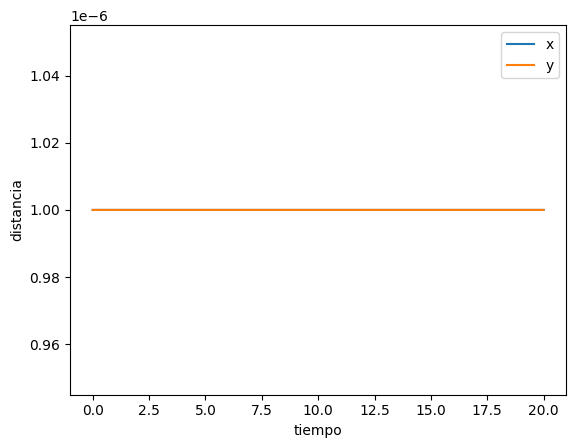

In [211]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

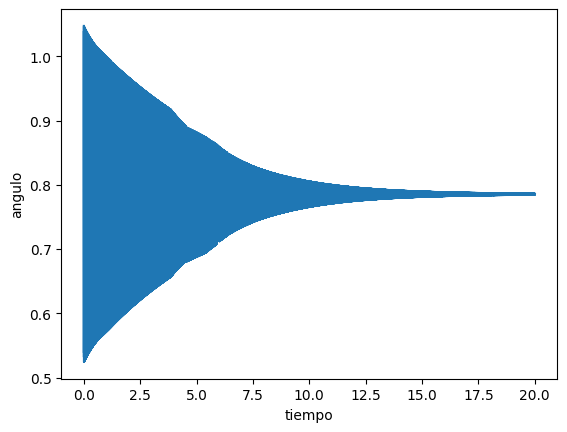

In [212]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [213]:
len(dipolo.solution.t)

271232

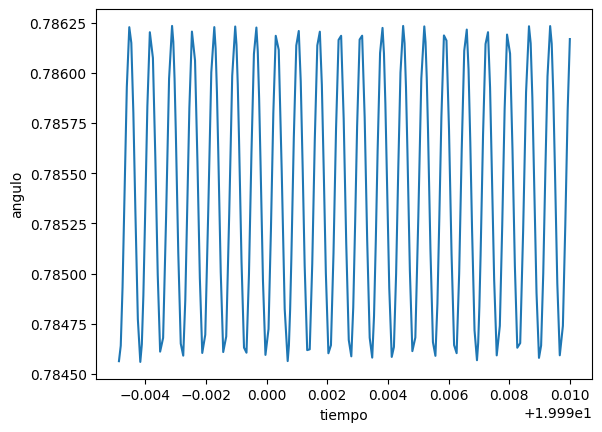

In [214]:
plt.plot(dipolo.solution.t[271032:271232], dipolo.solution.y[6][271032:271232])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [215]:
fields = [
    CargaPuntual2D()
]


dipolo = DipoloElectrico2D(PI/3, pos_draw=np.array([1, 1, 0]), t_end=30,
                           fps=30, pos=np.array([1e-6, 1e-6, 0]),
                           fields=fields,
                           set_time_interval=False)

theta = 1.0471975511965976
self.pos[0] = 1e-06
l = [7.00000000e-08 1.21243557e-07 0.00000000e+00]
p = [1.1200000e-26 1.9398969e-26 0.0000000e+00]
I = 1.9600000000000039e-31
E = [508.55119703 508.55119703   0.        ]
tau = -4.1695955221252065e-24
dE_r = [[ 1.14304449e-18  7.14134823e-31  0.00000000e+00]
 [ 7.14134823e-31  1.14304449e-18  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.28608899e-18]]
alpha = -21273446.541455094
a_x = 1.2802098316462741e-28
------------
iterations = 902
[theta, omega] =  [1.0471975511965976, 0.0]


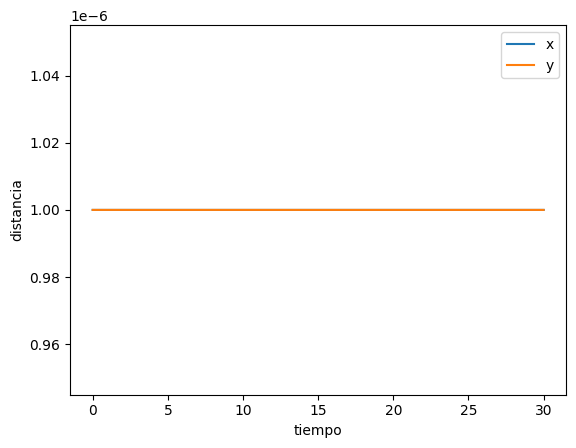

In [216]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

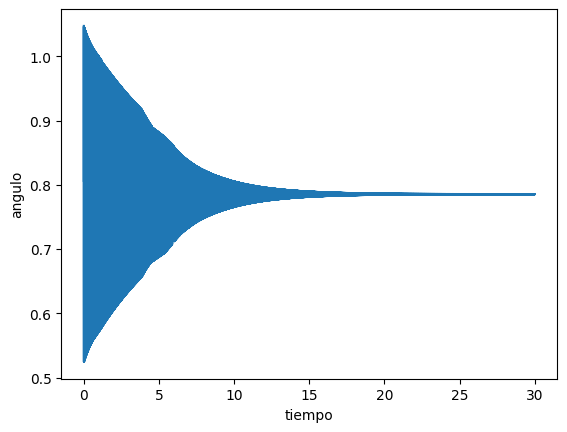

In [217]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [218]:
len(dipolo.solution.t)

414675

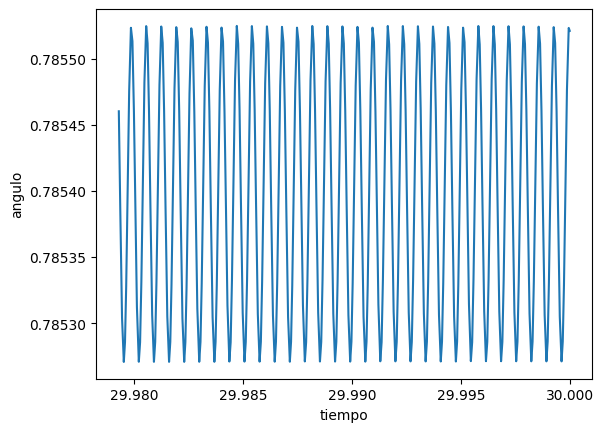

In [219]:
plt.plot(dipolo.solution.t[414375:414675], dipolo.solution.y[6][414375:414675])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

### Campo generadopor placas paralelas

In [222]:
class Placas2D(VMobject):

    def __init__(self, ancho=0.5, alto=7.5, E=500e3, E_draw=1):
        
        super().__init__()
        
        self.ancho = ancho
        self.alto = alto
        self.E = E
        self.E_draw = E_draw
        self.create()
        
        
    def create(self):
        
        placa_positiva = Rectangle(width=self.ancho, height=self.alto, color=RED_B)\
                         .set_fill(RED_E, 1).move_to(LEFT * (7.0 - self.ancho))
        placa_negativa = Rectangle(width=self.ancho, height=self.alto, color=BLUE)\
                         .set_fill(BLUE_E, 1).move_to(RIGHT * (7.0 - self.ancho))
        
        self.add(placa_positiva, placa_negativa)
        
        
    def campo(self, p, E_mag):
        
        E = 0
        
        height_half_screen = ScreenRectangle().height
        
        # hay campo solo en el espacio entre las placas
        if p[0] > (LEFT[0] * (7.0 - self.ancho)) \
            and p[0] < (RIGHT[0] * (7.0 - self.ancho)) \
            and p[1] > -height_half_screen + (height_half_screen - self.alto / 2) \
            and p[1] < height_half_screen - (height_half_screen - self.alto / 2):
                E = E_mag
        
        return np.array([
            E, # x
            0, # y
            0  # z
        ])

    
    def campo_draw(self, p):
        return self.campo(p, self.E_draw)
    
    
    def campo_real(self, p):
        return self.campo(p, self.E)

In [238]:
fields = [
    Placas2D(E=1.6e-4)
]


dipolo = DipoloElectrico2D(PI/4, pos_draw=np.array([1, 1, 0]), t_end=30,
                           fps=30, pos=np.array([1, 1, 0]),
                           fields=fields)

theta = 0.7853981633974483
self.pos[0] = 1
l = [9.89949495e-08 9.89949495e-08 0.00000000e+00]
p = [1.58391919e-26 1.58391919e-26 0.00000000e+00]
I = 1.9600000037209575e-31
E = [0.00016 0.      0.     ]
tau = -2.534270706178177e-30
dE_r = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
alpha = -12.92995255799488
a_x = 0.0
------------
iterations = 902
[theta, omega] =  [0.7853981633974483, 0.0]


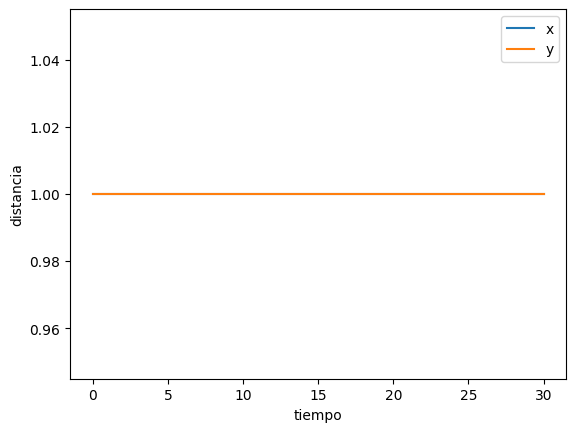

In [239]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

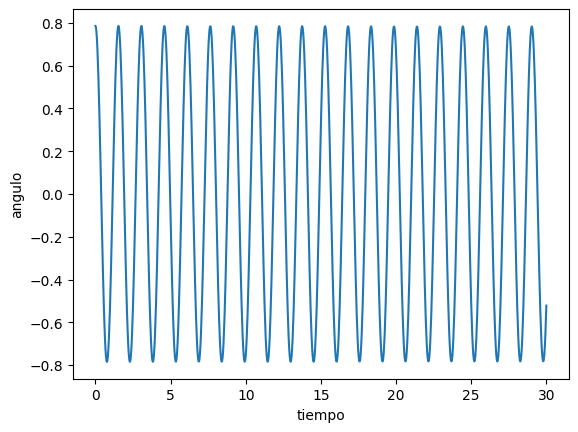

In [240]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [243]:
TOTAL_TIME = 30


class Example(Scene):

    def construct(self):
        
        fields = [
            Placas2D(E=1.6e-4)
        ]
        
        for field in fields:
            self.add(field)
            field.set_z_index(10)
        
        def func_e_field(p):
            total_field = np.array([0., 0., 0.])
            for field in fields:
                total_field += field.campo_draw(p)
            return total_field
        
        vector_field = ArrowVectorField(func_e_field)
        vector_field._alpha = 1
        
        def show_field(mob, dt):
            # valor de alpha que quiero quitar en 3 segundos, el dt se usa para que el calculo considere fps y TOTAL_TIME
            mob._alpha = mob._alpha - (0.65*dt/3) if mob._alpha > 0.35 else 0.35
            for subm in mob.submobjects:
                subm.set_opacity(mob._alpha)
            
        vector_field.add_updater(show_field)
        self.add(vector_field)
        
        
        initial_angle = PI/4 # respecto al eje horizontal

        dipolo = DipoloElectrico2D(initial_angle, pos_draw=np.array([1, 1, 0]), t_end=TOTAL_TIME,
                                   fps=self.camera.frame_rate, 
                                   fields=fields, pos=np.array([0, 0, 0]))
        dipolo.save_state()
        dipolo._counter = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            #mob.rotate(mob.solution.y[0][mob._counter])
            mob.rotate(mob.solution.y[6][mob._counter])
            mob.move_to([mob.solution.y[0][mob._counter] + mob.pos_draw[0], 
                         mob.solution.y[1][mob._counter] + mob.pos_draw[1], 
                         mob.solution.y[2][mob._counter] + mob.pos_draw[2]])
            mob._counter += 1
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        
        
        self.wait(TOTAL_TIME)
        

%time %manim $_RV

theta = 0.7853981633974483
self.pos[0] = 0
l = [9.89949494e-08 9.89949494e-08 0.00000000e+00]
p = [1.58391919e-26 1.58391919e-26 0.00000000e+00]
I = 1.9600000000000001e-31
E = [0.00016 0.      0.     ]
tau = -2.5342707037725867e-30
dE_r = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
alpha = -12.929952570268298
a_x = 0.0
------------
iterations = 902
[theta, omega] =  [0.7853981633974483, 0.0]


CPU times: total: 4min 19s
Wall time: 4min 20s


In [244]:
TOTAL_TIME = 30


class Example(Scene):

    def construct(self):
        
        fields = [
            Placas2D(E=1.6e-4)
        ]
        
        for field in fields:
            self.add(field)
            field.set_z_index(10)
        
        def func_e_field(p):
            total_field = np.array([0., 0., 0.])
            for field in fields:
                total_field += field.campo_draw(p)
            return total_field
        
        vector_field = ArrowVectorField(func_e_field)
        vector_field._alpha = 1
        
        def show_field(mob, dt):
            # valor de alpha que quiero quitar en 3 segundos, el dt se usa para que el calculo considere fps y TOTAL_TIME
            mob._alpha = mob._alpha - (0.65*dt/3) if mob._alpha > 0.35 else 0.35
            for subm in mob.submobjects:
                subm.set_opacity(mob._alpha)
            
        vector_field.add_updater(show_field)
        self.add(vector_field)
        
        
        initial_angle = 3*PI/4 # respecto al eje horizontal

        dipolo = DipoloElectrico2D(initial_angle, pos_draw=np.array([1, 1, 0]), t_end=TOTAL_TIME,
                                   fps=self.camera.frame_rate, 
                                   fields=fields, pos=np.array([0, 0, 0]))
        dipolo.save_state()
        dipolo._counter = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            #mob.rotate(mob.solution.y[0][mob._counter])
            mob.rotate(mob.solution.y[6][mob._counter])
            mob.move_to([mob.solution.y[0][mob._counter] + mob.pos_draw[0], 
                         mob.solution.y[1][mob._counter] + mob.pos_draw[1], 
                         mob.solution.y[2][mob._counter] + mob.pos_draw[2]])
            mob._counter += 1
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        
        
        self.wait(TOTAL_TIME)
        

%time %manim $_RV

theta = 2.356194490192345
self.pos[0] = 0
l = [-9.89949494e-08  9.89949494e-08  0.00000000e+00]
p = [-1.58391919e-26  1.58391919e-26  0.00000000e+00]
I = 1.9600000000000001e-31
E = [0.00016 0.      0.     ]
tau = -2.5342707037725867e-30
dE_r = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
alpha = -12.929952570268298
a_x = 0.0
------------
iterations = 902
[theta, omega] =  [2.356194490192345, 0.0]


CPU times: total: 6min 4s
Wall time: 6min 5s


### Con más de un generador de campo

In [255]:
%time

fields = [
    Placas2D(E=1.6e-4),
    CargaPuntual2D()
]


dipolo = DipoloElectrico2D(PI/4, pos_draw=np.array([1, 1, 0]), t_end=30,
                           fps=30,
                           fields=fields)

CPU times: total: 0 ns
Wall time: 0 ns
theta = 0.7853981633974483
self.pos[0] = 0.006
l = [9.89949494e-08 9.89949494e-08 0.00000000e+00]
p = [1.58391919e-26 1.58391919e-26 0.00000000e+00]
I = 1.960000000011614e-31
E = [1.74126422e-04 1.41264221e-05 0.00000000e+00]
tau = -2.534270703780095e-30
dE_r = [[-0.0011772  -0.00353161  0.        ]
 [-0.00353161 -0.0011772   0.        ]
 [ 0.          0.          0.0023544 ]]
alpha = -12.92995257022999
a_x = -7.458370370791702e-13
------------
iterations = 902
[theta, omega] =  [0.7853981633974483, 0.0]


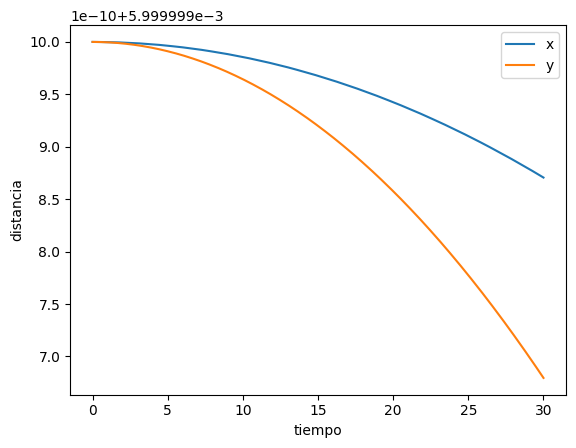

In [256]:
plt.plot(dipolo.solution.t, dipolo.solution.y[0], label="x")
plt.plot(dipolo.solution.t, dipolo.solution.y[1], label="y")
plt.xlabel('tiempo')
plt.ylabel('distancia')
plt.legend()
plt.show()

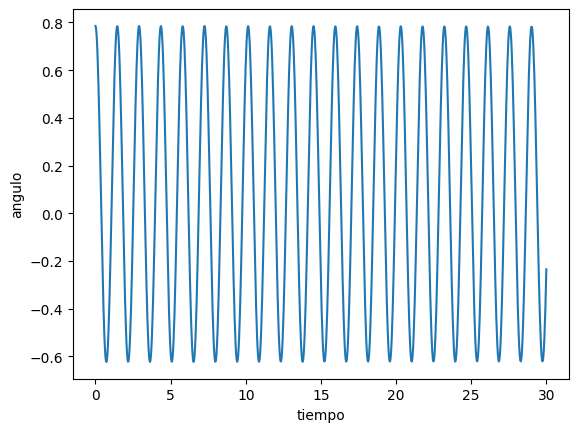

In [257]:
plt.plot(dipolo.solution.t, dipolo.solution.y[6])
plt.xlabel('tiempo')
plt.ylabel('angulo')
plt.show()

In [259]:
TOTAL_TIME = 30


class Example(Scene):

    def construct(self):
        
        fields = [
            Placas2D(E=1.6e-4),
            CargaPuntual2D()
        ]
        
        for field in fields:
            self.add(field)
            field.set_z_index(10)
        
        def func_e_field(p):
            total_field = np.array([0., 0., 0.])
            for field in fields:
                total_field += field.campo_draw(p)
            return total_field
        
        vector_field = ArrowVectorField(func_e_field)
        vector_field._alpha = 1
        
        def show_field(mob, dt):
            # valor de alpha que quiero quitar en 3 segundos, el dt se usa para que el calculo considere fps y TOTAL_TIME
            mob._alpha = mob._alpha - (0.65*dt/3) if mob._alpha > 0.35 else 0.35
            for subm in mob.submobjects:
                subm.set_opacity(mob._alpha)
            
        vector_field.add_updater(show_field)
        self.add(vector_field)
        
        
        initial_angle = PI/4 # respecto al eje horizontal

        dipolo = DipoloElectrico2D(initial_angle, pos_draw=np.array([1, 1, 0]), t_end=TOTAL_TIME,
                                   fps=self.camera.frame_rate, 
                                   fields=fields,
                                   longitud_escala=[140e-9, 420e-9])
        dipolo.save_state()
        dipolo._counter = 0
        
        def dipolo_dinamica(mob, dt):
            mob.restore()
            mob.rotate(mob.solution.y[6][mob._counter])
            mob.move_to([(mob.solution.y[0][mob._counter]-6e-3)/1e-10 + mob.pos_draw[0], 
                         (mob.solution.y[1][mob._counter]-6e-3)/1e-10 + mob.pos_draw[1], 
                         (mob.solution.y[2][mob._counter]-6e-3)/1e-10 + mob.pos_draw[2]])
            mob._counter += 1
            
        dipolo.add_updater(dipolo_dinamica)
        self.add(dipolo)
        
        
        self.wait(TOTAL_TIME)
        

%time %manim $_RV

theta = 0.7853981633974483
self.pos[0] = 0.006
l = [9.89949494e-08 9.89949494e-08 0.00000000e+00]
p = [1.58391919e-26 1.58391919e-26 0.00000000e+00]
I = 1.960000000011614e-31
E = [1.74126422e-04 1.41264221e-05 0.00000000e+00]
tau = -2.534270703780095e-30
dE_r = [[-0.0011772  -0.00353161  0.        ]
 [-0.00353161 -0.0011772   0.        ]
 [ 0.          0.          0.0023544 ]]
alpha = -12.92995257022999
a_x = -7.458370370791702e-13
------------
iterations = 902
[theta, omega] =  [0.7853981633974483, 0.0]


CPU times: total: 4min 49s
Wall time: 4min 50s
